In [1]:
import numpy as np
import pandas as pd

import torch 
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

from torchsummary import summary
import matplotlib.pyplot as plt

/home/vlad/miniconda3/envs/yolov8/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
n_per_class = 1000
img_size = 91

x = np.linspace(-4,4,img_size)
X, Y = np.meshgrid(x,x)

widths = [1.8, 2.4]

images = torch.zeros(2*n_per_class,1,img_size,img_size)
labels = torch.zeros(2*n_per_class)

for i in range(2*n_per_class):
    ro = 2*np.random.randn(2)
    G = np.exp(- ( (X-ro[0])**2 + (Y-ro[1])**2) / (2*widths[i%2]**2))
    
    G = G + np.random.randn(img_size, img_size)/5
    
    images[i, :, :, :] = torch.Tensor(G).view(1, img_size, img_size)
    
    labels[i] = i%2
    
labels = labels[:, None]

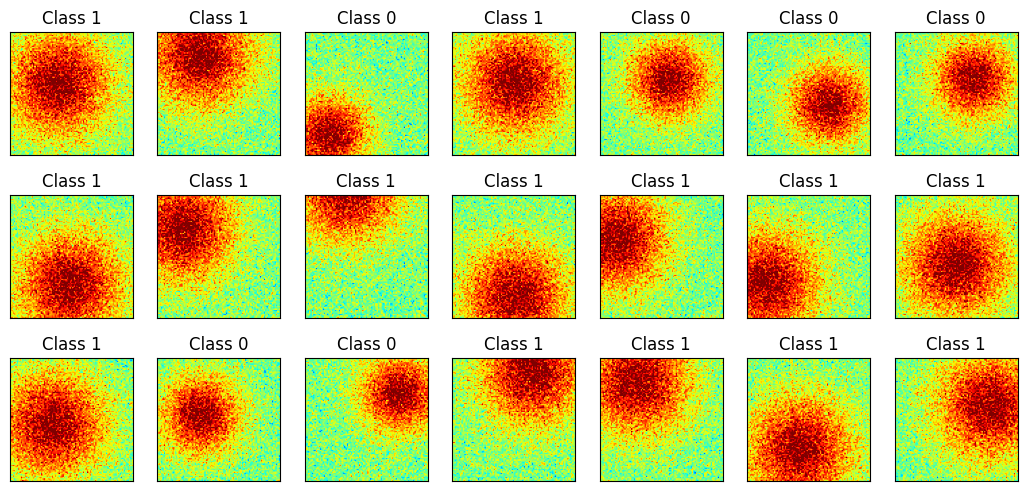

In [3]:
fig, axs = plt.subplots(3,7,figsize=(13,6))

for i, ax in enumerate(axs.flatten()):
    which_pic = np.random.randint(2*n_per_class)
    G = np.squeeze(images[which_pic, :,:])
    ax.imshow(G, vmin=-1, vmax=1, cmap='jet')
    ax.set_title(f'Class {int(labels[which_pic].item())}')
    ax.set_xticks([])
    ax.set_yticks([])
    
plt.show()

In [4]:
train_data, test_data, train_labels, test_labels = train_test_split(images, labels, test_size=.1)

train_dataset = TensorDataset(train_data, train_labels)
test_dataset = TensorDataset(test_data, test_labels)

batch_size = 32

train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size = test_dataset.tensors[0].shape[0])

In [5]:
print(train_loader.dataset.tensors[0].shape)
print(train_loader.dataset.tensors[1].shape)
print(test_loader.dataset.tensors[0].shape)
print(test_loader.dataset.tensors[1].shape)

torch.Size([1800, 1, 91, 91])
torch.Size([1800, 1])
torch.Size([200, 1, 91, 91])
torch.Size([200, 1])


In [6]:
def create_model():
    
    class MNISTModel(nn.Module):
        def __init__(self):
            super().__init__()
            
            self.conv1 = nn.Conv2d(1,6,3,padding=1) # Output with size (91, 91)
            self.conv2 = nn.Conv2d(6,4,3, padding=1) # Output with size (45,45)
            self.linear = nn.Linear(22*22*4, 50)
            self.output = nn.Linear(50, 1)
            
            
        def forward(self, x):
            conv1act = F.relu(self.conv1(x))
            x = F.avg_pool2d(conv1act, (2, 2))
            
            conv2act = F.relu(self.conv2(x))
            x = F.avg_pool2d(conv2act, (2, 2))
            
            x = x.reshape(x.shape[0], -1)
            x = F.relu(self.linear(x))
            x = self.output(x)
        
            return x, conv1act, conv2act
        
    model = MNISTModel()
        
    loss_func = nn.BCEWithLogitsLoss()
        
    optimizer = torch.optim.Adam(model.parameters(), lr=.001)
        
    return model, loss_func, optimizer

In [7]:
model, loss_func, optimizer = create_model()

X, y = next(iter(train_loader))

yHat, featmap1, featmap2 = model(X)

loss = loss_func(yHat, y)
print('Predicted category:')
print(yHat.shape)
print('\nFeature map after conv1:')
print(featmap1.shape)
print('\nFeature map after conv2:')
print(featmap2.shape)

Predicted category:
torch.Size([32, 1])

Feature map after conv1:
torch.Size([32, 6, 91, 91])

Feature map after conv2:
torch.Size([32, 4, 45, 45])


In [8]:
summary(model, (1, 91, 91), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 91, 91]              60
            Conv2d-2            [-1, 4, 45, 45]             220
            Linear-3                   [-1, 50]          96,850
            Linear-4                    [-1, 1]              51
Total params: 97,181
Trainable params: 97,181
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.03
Forward/backward pass size (MB): 0.44
Params size (MB): 0.37
Estimated Total Size (MB): 0.84
----------------------------------------------------------------


In [9]:
num_of_epochs = 20
def train_model():
    model, loss_func, optimizer = create_model()
    
    train_losses = torch.zeros(num_of_epochs)
    test_losses = torch.zeros(num_of_epochs)
    train_acc = torch.zeros(num_of_epochs)
    test_acc = torch.zeros(num_of_epochs)
    
    for epoch in range(num_of_epochs):
        model.train()
        batch_acc = []
        batch_loss = []
        for X,y in  train_loader:
            yHat = model(X)[0]
            loss = loss_func(yHat, y)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            batch_loss.append(loss.item())
            
            batch_acc.append(torch.mean(( (yHat > .5) == y).float()).item())
            
        train_losses[epoch] = np.mean(batch_loss)
        train_acc[epoch] = 100*np.mean(batch_acc)
        
        model.eval()
        X,y = next(iter(test_loader))
        with torch.no_grad():
            yHat = model(X)[0]
            loss = loss_func(yHat, y)
        
        test_losses[epoch] = loss.item()
        test_acc[epoch] = 100*torch.mean(( (yHat > .5) == y).float()).item()
        
    return train_losses, test_losses, train_acc, test_acc, model

In [10]:
train_loss, test_loss, train_acc, test_acc, model = train_model()

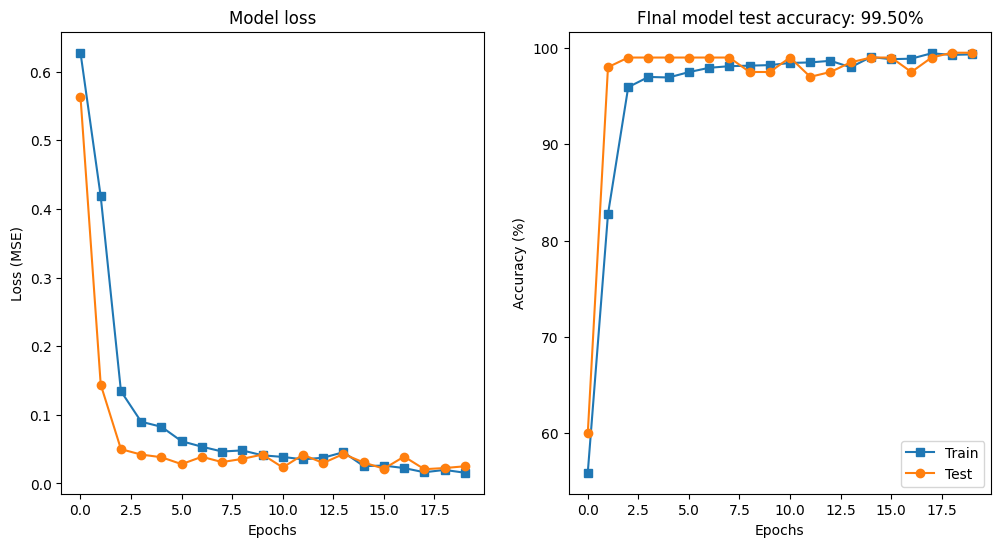

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].plot(train_loss, 's-', label='Train')
ax[0].plot(test_loss, 'o-', label='Test')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss (MSE)')
ax[0].set_title('Model loss')

ax[1].plot(train_acc, 's-', label='Train')
ax[1].plot(test_acc, 'o-', label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_title(f'FInal model test accuracy: {test_acc[-1]:.2f}%')
ax[1].legend()

plt.show()

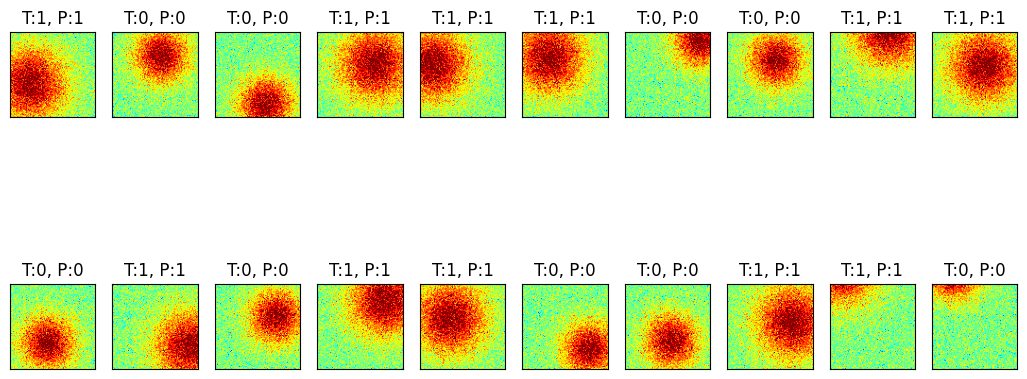

In [12]:
X, y = next(iter(test_loader))
yHat, feature1, feature2 = model(X)

fig, axs = plt.subplots(2, 10,figsize=(13,6))

for i, ax in enumerate(axs.flatten()):
    G = torch.squeeze(X[i, 0, :, :])
    ax.imshow(G, vmin=-1, vmax=1, cmap='jet')
    t = ( int(y[i].item()), int(yHat[i].item()>0) )
    ax.set_title(f'T:{t[0]}, P:{t[1]}')
    ax.set_xticks([])
    ax.set_yticks([])
    
plt.show()

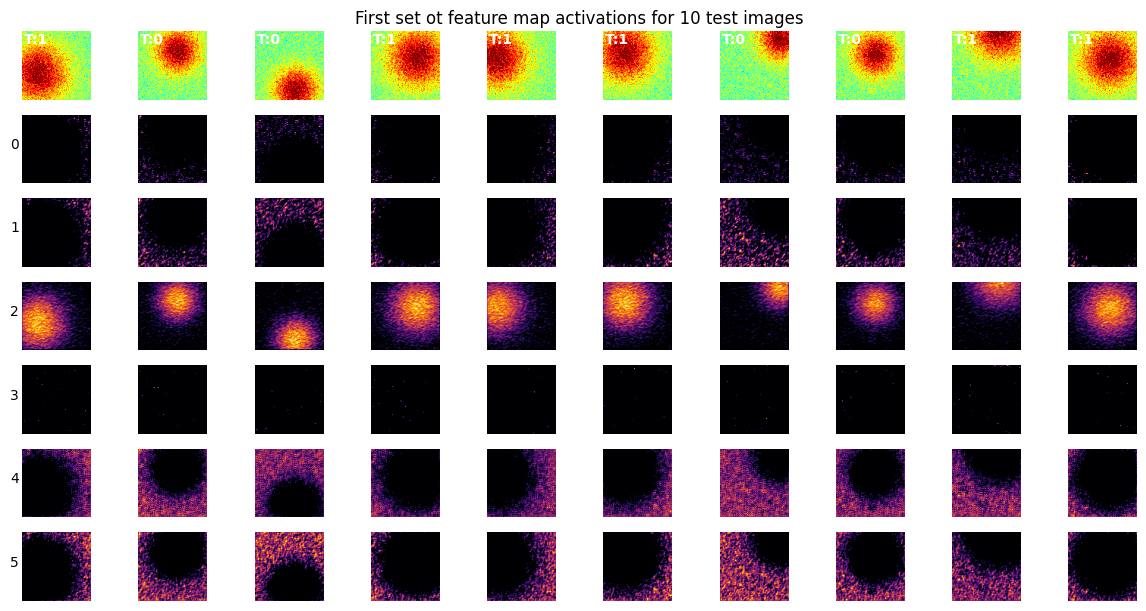

In [13]:
fig, axs = plt.subplots(7, 10, figsize=(12,6))

for pici in range(10):
    img = X[pici, 0, :, :].detach()
    axs[0,pici].imshow(img, cmap='jet', vmin=-1, vmax=1)
    axs[0, pici].axis('off')
    axs[0, pici].text(2,2,f"T:{int(y[pici].item())}", ha='left', va='top', color='w', fontweight='bold')
    
    for feati in range(6):
        img = feature1[pici, feati, :, :].detach()
        axs[feati+1,pici].imshow(img, cmap='inferno', vmin=0, vmax=torch.max(img)*.9)
        axs[feati+1, pici].axis('off')
        axs[feati+1, pici].text(-5,45,feati, ha='right') if pici==0 else None
        
plt.tight_layout()
plt.suptitle('First set ot feature map activations for 10 test images', x=.5, y=1.01)
plt.show()

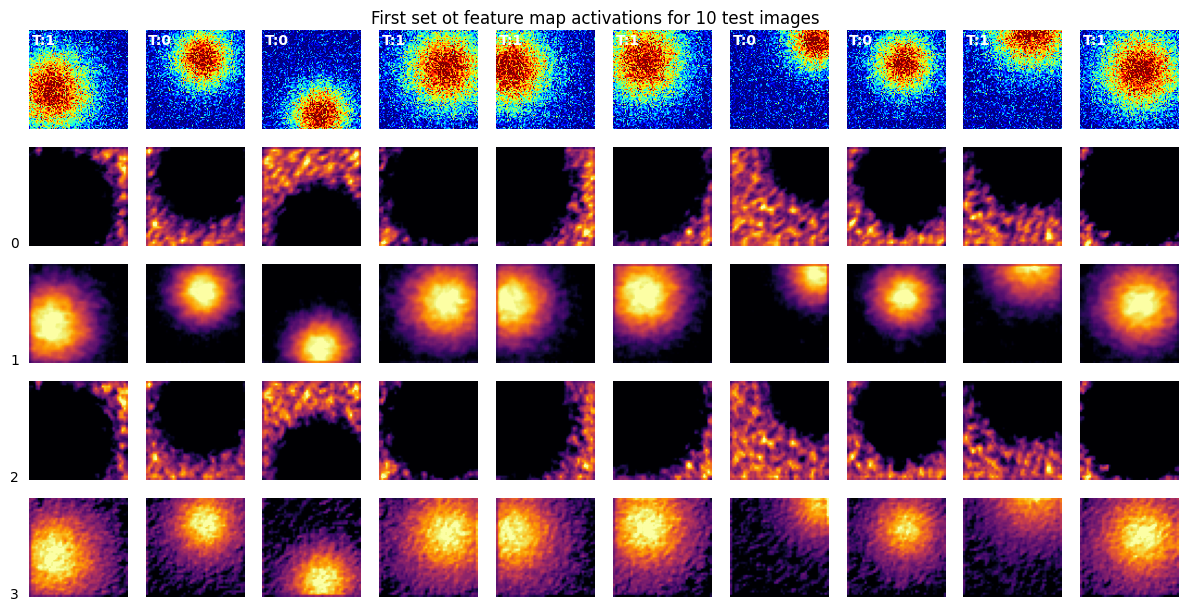

In [14]:
fig, axs = plt.subplots(5, 10, figsize=(12,6))

for pici in range(10):
    img = X[pici, 0, :, :].detach()
    axs[0,pici].imshow(img, cmap='jet', vmin=0, vmax=1)
    axs[0, pici].axis('off')
    axs[0, pici].text(2,2,f"T:{int(y[pici].item())}", ha='left', va='top', color='w', fontweight='bold')
    
    for feati in range(4):
        img = feature2[pici, feati, :, :].detach()
        axs[feati+1,pici].imshow(img, cmap='inferno', vmin=0, vmax=torch.max(img)*.9)
        axs[feati+1, pici].axis('off')
        axs[feati+1, pici].text(-5,45,feati, ha='right') if pici==0 else None
        
plt.tight_layout()
plt.suptitle('First set ot feature map activations for 10 test images', x=.5, y=1.01)
plt.show()

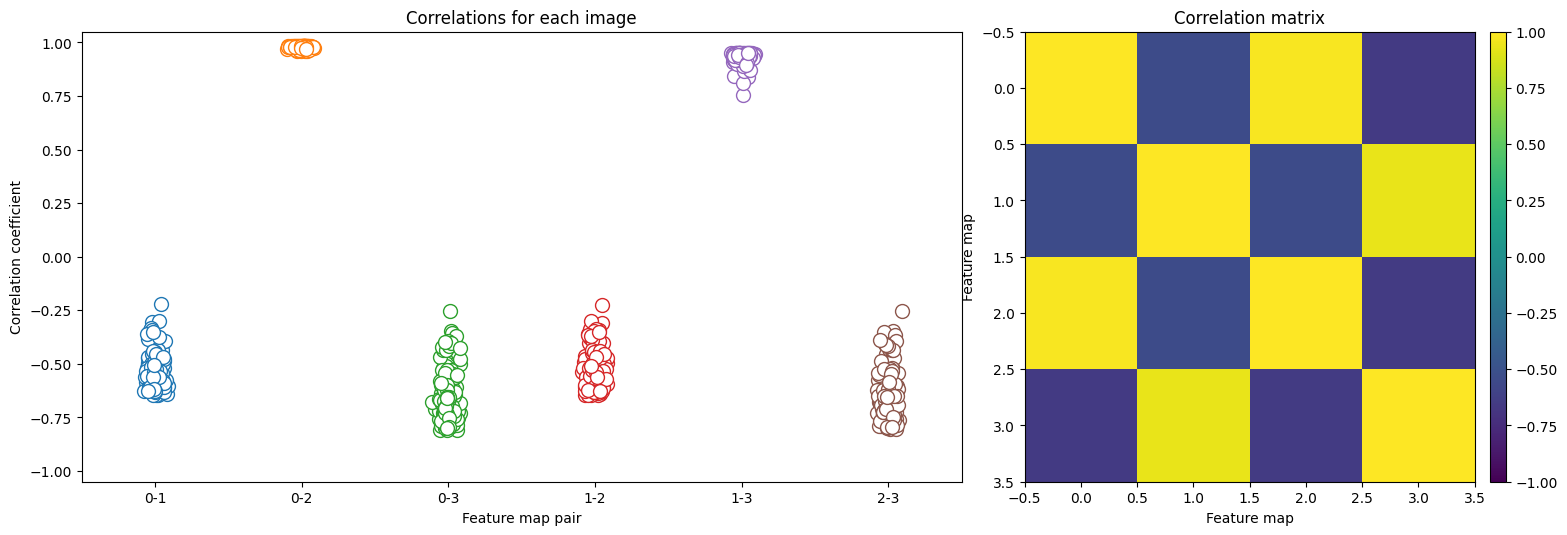

In [15]:
### correlations across the SECOND convolution layer

# convenient variables
nStim = feature2.shape[0]
nMaps = feature2.shape[1]
nCors = (nMaps*(nMaps-1))//2

# initialze the matrix of all correlation values
allrs = np.zeros((nStim,nCors))
Call  = np.zeros((nMaps,nMaps))

# loop over each stimulus
for i in range(nStim):

  # extract the vectorized feature maps from this image
  featmaps = feature2[i,:,:,:].view(nMaps,-1).detach()

  # compute the correlation matrix
  C = np.corrcoef(featmaps)
  Call += C

  # extract the unique correlations from the matrix
  idx = np.nonzero(np.triu(C,1))
  allrs[i,:] = C[idx]


# define the x-axis labels
xlab = []*nCors
for i in range(nCors):
  xlab.append('%s-%s' %(idx[0][i],idx[1][i]))




# now visualize the correlations
fig = plt.figure(figsize=(16,5))
ax0 = fig.add_axes([.1,.1,.55,.9]) # [left, bottom, width, height]
ax1 = fig.add_axes([.68,.1,.3,.9])
cax = fig.add_axes([.98,.1,.01,.9])

for i in range(nCors):
  ax0.plot(i+np.random.randn(nStim)/30,allrs[:,i],'o',markerfacecolor='w',markersize=10)

# make the plot more interpretable
ax0.set_xlim([-.5,nCors-.5])
ax0.set_ylim([-1.05,1.05])
ax0.set_xticks(range(nCors))
ax0.set_xticklabels(xlab)
ax0.set_xlabel('Feature map pair')
ax0.set_ylabel('Correlation coefficient')
ax0.set_title('Correlations for each image')


# now show the average correlation matrix
h = ax1.imshow(Call/nStim,vmin=-1,vmax=1)
ax1.set_title('Correlation matrix')
ax1.set_xlabel('Feature map')
ax1.set_ylabel('Feature map')
# add a colorbar
fig.colorbar(h,cax=cax)

plt.show()

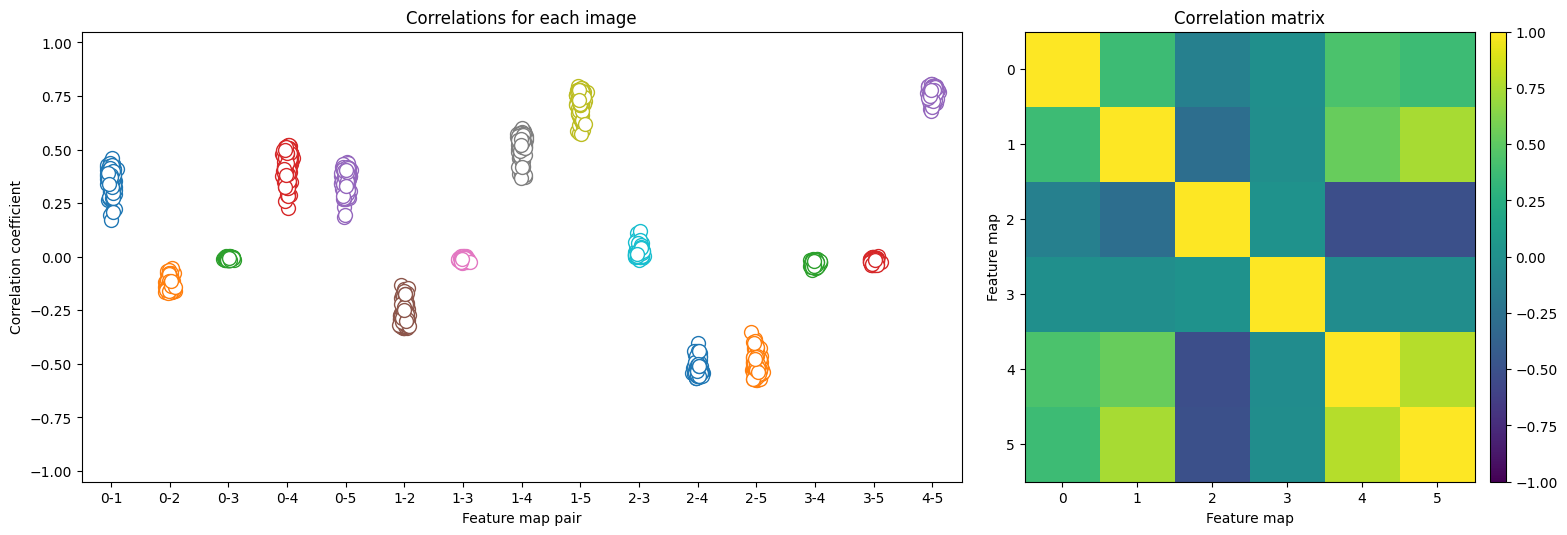

In [16]:
### correlations across the FIRST convolution layer

# convenient variables
nStim = feature1.shape[0]
nMaps = feature1.shape[1]
nCors = (nMaps*(nMaps-1))//2

# initialze the matrix of all correlation values
allrs = np.zeros((nStim,nCors))
Call  = np.zeros((nMaps,nMaps))

# loop over each stimulus
for i in range(nStim):

  # extract the vectorized feature maps from this image
  featmaps = feature1[i,:,:,:].view(nMaps,-1).detach()

  # compute the correlation matrix
  C = np.corrcoef(featmaps)
  Call += C

  # extract the unique correlations from the matrix
  idx = np.nonzero(np.triu(C,1))
  allrs[i,:] = C[idx]


# define the x-axis labels
xlab = []*nCors
for i in range(nCors):
  xlab.append('%s-%s' %(idx[0][i],idx[1][i]))




# now visualize the correlations
fig = plt.figure(figsize=(16,5))
ax0 = fig.add_axes([.1,.1,.55,.9]) # [left, bottom, width, height]
ax1 = fig.add_axes([.68,.1,.3,.9])
cax = fig.add_axes([.98,.1,.01,.9])

for i in range(nCors):
  ax0.plot(i+np.random.randn(nStim)/30,allrs[:,i],'o',markerfacecolor='w',markersize=10)

# make the plot more interpretable
ax0.set_xlim([-.5,nCors-.5])
ax0.set_ylim([-1.05,1.05])
ax0.set_xticks(range(nCors))
ax0.set_xticklabels(xlab)
ax0.set_xlabel('Feature map pair')
ax0.set_ylabel('Correlation coefficient')
ax0.set_title('Correlations for each image')


# now show the average correlation matrix
h = ax1.imshow(Call/nStim,vmin=-1,vmax=1)
ax1.set_title('Correlation matrix')
ax1.set_xlabel('Feature map')
ax1.set_ylabel('Feature map')
# add a colorbar
fig.colorbar(h,cax=cax)

plt.show()

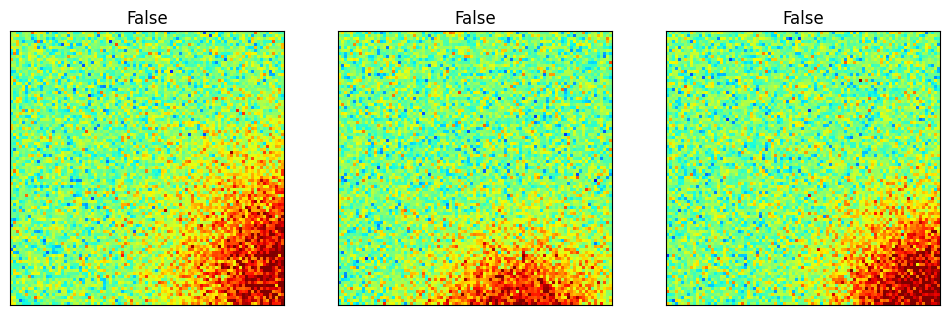

In [17]:
predictions = yHat > 0
falses = []
for i in range(len(yHat)):
    if predictions[i].float() != y[i]:
        falses.append(X[i, 0, :, :])
        
fig, axs = plt.subplots(1, len(falses), figsize=(12, 6))
for i, ax in enumerate(axs.flatten()):
    ax.imshow(torch.squeeze(falses[i]), vmin=-1, vmax=1, cmap='jet')
    ax.set_title('False')
    ax.set_xticks([])
    ax.set_yticks([])
plt.show()